The aim of this notebook is to demonstrate a strategy based on Candlestick patterns. This notebook is designed to be implemented in Quantopian's research environment. More commentary on the code can be found on AAAQuant's Candlestick Pattern Study blog at aaaquants.com.

In [73]:
import talib
import numpy as np
from matplotlib.pyplot import plot,show,subplots,legend,boxplot
import pandas as pd
from quantopian.pipeline.factors.morningstar import MarketCap
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import heapq

In [74]:
def make_pipeline(x):
    '''Create pipeline based on top x market cap'''
    mktCap = MarketCap()
    myMktCap = mktCap.top(x)
    pipe = Pipeline()
    pipe.set_screen(myMktCap)
    
    return pipe

In [75]:
def pipeline_output(x, d1):
    '''Run the pipeline and let user specify x market cap at certain date'''
    pipe = make_pipeline(x)
    myPipe = run_pipeline(pipe, start_date=d1, end_date=d1)
    
    return myPipe

In [76]:
def get_stocks(x, d1):
    '''Create list of stocks from multi index data frame for future analysis'''
    
    #Call the pipeline_output function and specify the market cap and date
    #myPipe is a  multi index dataframe with date and stocks as the indices
    myPipe = pipeline_output(x, d1)
    
    #Count the multi index to check there are correct number of stocks for the date. 
    #Assert will break the code if the number of stocks is incorrect.
    assert(myPipe.reset_index().groupby('level_0')['level_1'].nunique()[0] == x)
    
    #Extract stocks from second level of index
    #Iterate through stocks and create new list with just the symbols as strings from the index
    myStocks = myPipe.index.get_level_values(1)
    myStocks = [str(i.symbol) for i in myStocks]
    
    return myStocks

In [77]:
def forward_returns(priceData, periodList, x):
    '''Calculates the periodList forward return e.g. 1min; x: how many stocks to go over'''
    '''Adds priceData dataframe columns named FwdReturn1, FwdReturn5 for 1 min and 5 min fwd returns'''
    for period in periodList:
    #shifted for correlation analysis with indicator signal so they are on the same row for analysis 
        priceData['FwdReturn%s'%period] = (priceData['price'].pct_change(period*x)*100).shift(-period*x)
    
    return priceData

In [78]:
def prep_price_rets(x, d1, d2, freq, periodList):
    '''Calling above functions'''
    '''Generates multi index dataframe with columns for OHLC and different forward returns together'''
    
    #Call the get_stocks function to get list of stocks and name this list for future reference
    myStocks = get_stocks(x, d1)
    
    #Use get_pricing to retrieve OHLC and volume data for each stock in myStocks
    #priceData has been converted from panel to a multi index data frame
    #fields are volume and price otherwise stocks that do not have OHLC data for the minute are excluded, ruining our forward return calculations.
    priceData = get_pricing(myStocks, d1, d2, frequency=freq, fields=['volume','price']).fillna(0).to_frame()
    assert(priceData.reset_index().groupby('major')['minor'].nunique()[0] == x)  #checking all stocks are there
    
    #priceData = priceData['price']
    #priceData = priceData.unstack(level=[1]).resample('60min').ohlc().dropna().stack(level=[0])
    #priceData.columns = ['open_price','high','low','price']
    
    priceRets = forward_returns(priceData, periodList, x)
    
    return priceRets

In [79]:
def get_all_indicators(priceDf):
    a = []
    try:
        a.append(talib.CDL2CROWS(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDL3BLACKCROWS(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDL3INSIDE(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDL3LINESTRIKE(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDL3OUTSIDE(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDL3STARSINSOUTH(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDL3WHITESOLDIERS(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLABANDONEDBABY(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLADVANCEBLOCK(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLBELTHOLD(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLBREAKAWAY(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLCLOSINGMARUBOZU(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLCONCEALBABYSWALL(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLCOUNTERATTACK(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLDARKCLOUDCOVER(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLDOJI(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLDOJISTAR(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLDRAGONFLYDOJI(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLENGULFING(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLEVENINGDOJISTAR(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLEVENINGSTAR(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLGAPSIDESIDEWHITE(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLGRAVESTONEDOJI(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLHAMMER(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLHANGINGMAN(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLHARAMI(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLHARAMICROSS(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLHIGHWAVE(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLHIKKAKE(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLHIKKAKEMOD(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLHOMINGPIGEON(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLIDENTICAL3CROWS(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLINNECK(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLINVERTEDHAMMER(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLKICKING(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLKICKINGBYLENGTH(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLLADDERBOTTOM(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLLONGLEGGEDDOJI(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLLONGLINE(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLMARUBOZU(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLMATCHINGLOW(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLMATHOLD(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLMORNINGDOJISTAR(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLMORNINGSTAR(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLONNECK(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLPIERCING(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLRICKSHAWMAN(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLRISEFALL3METHODS(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLSEPARATINGLINES(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLSHOOTINGSTAR(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLSHORTLINE(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLSPINNINGTOP(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLSTALLEDPATTERN(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLSTICKSANDWICH(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLTAKURI(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLTASUKIGAP(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLTHRUSTING(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLTRISTAR(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLUNIQUE3RIVER(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLUPSIDEGAP2CROWS(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
        a.append(talib.CDLXSIDEGAP3METHODS(priceDf['open_price'],priceDf['high'],priceDf['low'],priceDf['price']))
    
    except:
        b = np.empty((len(priceDf),))
        b[:] = np.nan
        a.append(b)
        
    return np.array(a)

In [80]:
def prep_indicator(stockRets,INDICATOR):  #we will index reference the indicators
    inds = get_all_indicators(stockRets)
    ind = inds[INDICATOR]
    
    return ind

In [81]:
def initialise_signal_col(priceRets, INDICATOR,d1,d2,freq):
    '''Creates signal column starting with first stock'''
    
    stockRets = prep_stock_rets(priceRets,0,d1,d2,freq)
    ind = prep_indicator(stockRets,INDICATOR)
    stockRets['indicator'] = ind 
    priceRets['sig'] = stockRets['indicator']
    
    return priceRets
    

In [82]:
def prep_stock_rets(priceRets,i,d1,d2,freq):
    stockRets = get_pricing(priceRets.index.get_level_values(1)[i],d1,d2,frequency=freq)
    
    #stockRets = stockRets['price']
    #stockRets = stockRets.resample('60min').ohlc().dropna()
    #stockRets.columns = ['open_price','high','low','price']
    
    #since this does not have the minor axis of the equity name which is required to insert back into priceRets
    iterables = [stockRets.index, [priceRets.index.get_level_values(1)[i]]]
    new_index = pd.MultiIndex.from_product(iterables, names=['major', 'minor'])
    stockRets.index = new_index
    
    
    return stockRets

In [83]:
def new_signal_col(priceRets,x,INDICATOR,d1,d2,freq):
    '''Creates adjacent signal column for next stock, and then adds them to become one column'''
    
    for i in range(1,x):
        stockRets = prep_stock_rets(priceRets,i,d1,d2,freq)
        
        ind = prep_indicator(stockRets,INDICATOR)
        
        stockRets['indicator'] = ind 
        priceRets['sig1'] = stockRets['indicator']
        priceRets['sig'] = priceRets[['sig','sig1']].fillna(0).sum(axis=1)
        priceRets.drop('sig1',inplace=True,axis=1,errors='ignore')
    
    return priceRets

In [84]:
#Calling initalise signal and new signal column functions
#Returns priceRets a multi index dataframe with pricing data AND signal data 
def prep_signals(priceRets,x,INDICATOR,d1,d2,freq):
    '''Functions to create a signal column from above and normalises it'''
    
    priceRets = initialise_signal_col(priceRets,INDICATOR,d1,d2,freq)
    priceRets = new_signal_col(priceRets,x,INDICATOR,d1,d2,freq)
    priceRets['sig'] = priceRets['sig']/100
    
    return priceRets

In [85]:
def calc_pnl(priceRets, periodList):
    '''Calculates pnl by multiplying the fwd return and the signal for each period in periodList'''
    for period in periodList:
        priceRets['PnL%s'%period] = priceRets['FwdReturn%s'%period]*priceRets['sig']
        
    return priceRets

In [86]:
def check_signal_direction(priceRets, sigList, period):
    '''Makes list of checking if signal direction matches fwd returns'''
    '''+1 means signal correlated with return, -1 means signal is not correlated'''
    sigList = [0 if sig == 0 else 1 if np.sign(sig) == np.sign(priceRets['FwdReturn%s'%period][i]) else -1 for i,sig in enumerate(priceRets['sig'])]
    
    priceRets['Match%s'%period] = sigList
    sigList = []
    
    return priceRets, sigList

In [87]:
def prep_win_loss(priceRets, periodList):
    '''Calling above function and returns priceRets df with signals'''
    sigList = [] 
    for period in periodList:
        priceRets, sigList = check_signal_direction(priceRets, sigList, period)
    return priceRets 

In [88]:
def create_price_rets(x, d1, d2, freq, periodList, INDICATOR):
    '''Calls all above functions to form priceRets'''
    priceRets = prep_price_rets(x, d1, d2, freq, periodList)
    priceRets = prep_signals(priceRets,x,INDICATOR,d1,d2,freq)
    priceRets = calc_pnl(priceRets, periodList)
    priceRets = prep_win_loss(priceRets, periodList)
    
    return priceRets

In [89]:
def win_loss_ratio(priceRets,period):
    '''Calculates win loss ratio based on number of good matches over sum of good and bad matches'''
    goodMatch = float(len(priceRets[priceRets['Match%s'%period]==1]))
    badMatch = float(len(priceRets[priceRets['Match%s'%period]==-1]))
    
    if (goodMatch+badMatch) != 0.0:
        winLossRatio = goodMatch/(goodMatch+badMatch)
    else:
        winLossRatio = 0.0
    
    return winLossRatio

In [90]:
def all_win_loss_ratios(priceRets,periodList):
    '''Adds win loss ratios to list for each period in user specified period list'''
    '''Calls above function'''
    winLossRatios = []
    for period in periodList:
        winLossRatio = win_loss_ratio(priceRets,period)
        winLossRatios.append(winLossRatio)
        
    return winLossRatios

In [91]:
def scaled_win_loss_ratio(priceRets,period):
    '''Calculates win loss ratio but scaled by multiplying pnl'''
    '''We can make sure the returns made with correct predictions outweigh'''
    goodPnL = np.sum(priceRets[priceRets['Match%s'%period]==1]['PnL%s'%period])
    badPnL = abs(np.sum(priceRets[priceRets['Match%s'%period]==-1]['PnL%s'%period]))
    
    if (goodPnL+badPnL) != 0.0:
        scaledWinLossRatio = goodPnL/(goodPnL+badPnL)
    else:
        scaledWinLossRatio = 0.0
    
    return scaledWinLossRatio

In [92]:
def all_scaled_win_loss_ratios(priceRets,periodList):
    '''Adds scaled win loss ratios to list for each period in user specified period list'''
    scaledWinLossRatios = []
    for period in periodList:
        scaledWinLossRatio = scaled_win_loss_ratio(priceRets,period)
        scaledWinLossRatios.append(scaledWinLossRatio)
    
    return scaledWinLossRatios

In [93]:
def sum_pos(x,tradeSign):
    '''Returns number of pos/neg signals for a certain date'''
    sums = 0
    for y in x: 
        if y == tradeSign:
            sums = sums + 1
    return sums

In [94]:
def longs_shorts_sum(priceRets):
    longs = priceRets['sig'].groupby(priceRets.index.get_level_values(0)).apply(lambda x: sum_pos(x,1))
    shorts = priceRets['sig'].groupby(priceRets.index.get_level_values(0)).apply(lambda x: sum_pos(x,-1))
    
    return longs,shorts

In [95]:
def pos_count(abc,period):
    '''Counts long/short positions for each date taking into account exited positions from period minutes ago'''
    xyz = abc.shift(period).fillna(0)
    
    prevPosCount = 0
    posCounts = []
    abcxyz = zip(abc,xyz)
    
    for v in abcxyz:
        posCount = v[0] + prevPosCount - v[1]
        posCounts.append(posCount)
        
        prevPosCount = posCount
        
    return np.array(posCounts)

In [96]:
def max_pos(priceRets,period):
    '''We find the 10th highest number of long positions at any one time that we hold to divide returns with'''
    longs,shorts = longs_shorts_sum(priceRets)
    longPosCount = pos_count(longs,period)
    shortPosCount = pos_count(shorts,period)
    netPosCount = longPosCount - shortPosCount
    maxNetPos = int(0.8*max(netPosCount))  #sometimes we will be overleveraged
    
    return maxNetPos,netPosCount

In [97]:
def mean_pnl(priceRets,period):
    
    priceRets['PnL%s'%period] = priceRets['PnL%s'%period].fillna(0)
    maxNetPos,netPosCount = max_pos(priceRets,period)
    
    meanPnL = priceRets['PnL%s'%period].groupby(level='major').apply(lambda x: np.sum(x))/float(maxNetPos)
    meanPnL = meanPnL.replace(np.inf, 0)
    meanPnL = meanPnL.replace(-np.inf,0)
    
    return meanPnL

In [98]:
def index_names():
    indNames = []
    for indName in dir(talib):
        if 'CDL' in indName:
            indNames.append(indName)
    
    return indNames

In [99]:
def prep_heatmap(visualDf,myMetric,periodList,INDICATOR):
    '''Preparing visualisation dataframes'''
    
    indName = index_names()[INDICATOR]
    visualDf['%s'%indName] = pd.Series(myMetric,index=periodList)
    
    return visualDf

In [100]:
def plot_heatmap(heatmapDf,mid):
    subplots(figsize=(35,10))
    sns.heatmap(heatmapDf,center=mid,annot=True,cmap="coolwarm_r")

In [101]:
def find_indicator(INDICATOR_NAME):
    return [i for i,ind in enumerate(index_names()) if ind=='%s'%INDICATOR_NAME][0]

In [102]:
def prep_visuals(visualDf1,priceRets,period):
    visualDf1['meanPnL%s'%period] = mean_pnl(priceRets,period).fillna(0)
    
    return visualDf1

In [103]:
def plot_visuals(visualDf1,periodList,priceRets):
    sns.boxplot(visualDf1)
    plt.show()
    plt.clf()
    sns.violinplot(visualDf1)
    plt.show()
    plt.clf()
    
    for period in periodList:
        plt.plot((np.cumsum(visualDf1['meanPnL%s'%period])),label=period)
    plt.legend(loc='best')
    plt.show()
    
    for period in periodList:
        netPosCount = max_pos(priceRets,period)[1]                         
        sns.distplot(netPosCount,bins=20)
        plt.title('Net Positions %s'%period)
        plt.show()
        plt.clf()

In [104]:
def metrics_per_trade(priceRets,periodList):
    numTrades = len(priceRets.dropna()[priceRets.dropna()['sig']!=0])
    avgPnLs = []
    
    for period in periodList:
        if numTrades != 0: 
            avgPnL = np.sum(visualDf1['meanPnL%s'%period])/numTrades
        else:
            avgPnL = 0 
        avgPnLs.append(avgPnL)

    avgPnLs = pd.Series(avgPnLs,index=periodList)
    plt.plot(avgPnLs)
    plt.xticks(periodList)
    plt.show()
    
    print("This strategy enters %s long and short trades."%str(numTrades))

In [105]:
def plot_win_loss(priceRets,periodList):
    winLossRatios = all_win_loss_ratios(priceRets,periodList)
    scaledWinLossRatios = all_scaled_win_loss_ratios(priceRets,periodList)
    
    plt.plot(winLossRatios,label='Win Loss Ratio')
    plt.plot(scaledWinLossRatios,label='Scaled Win Loss Ratio')
    plt.xticks(periodList)
    plt.legend()
    plt.show()

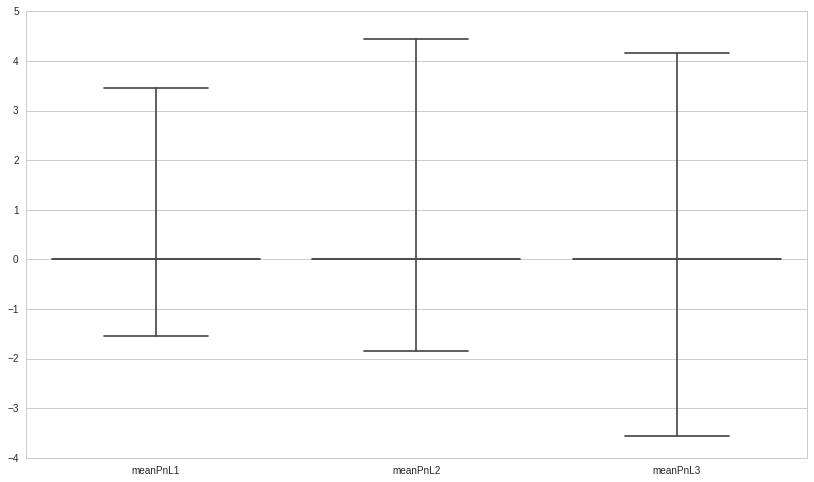

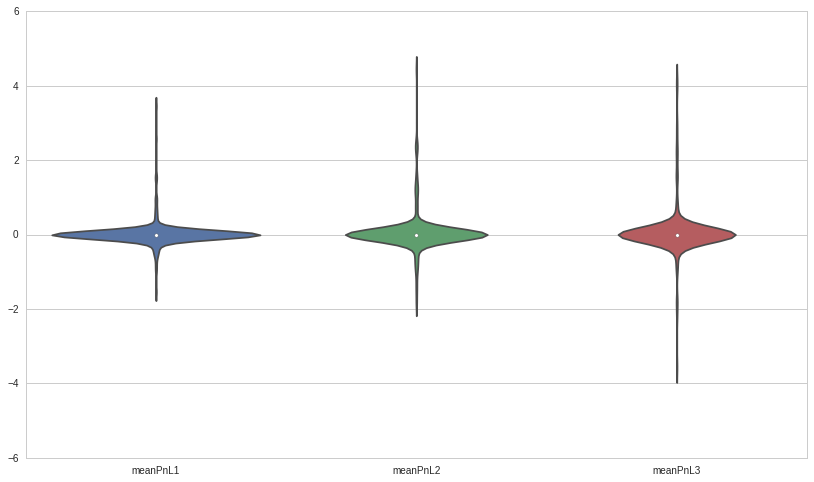

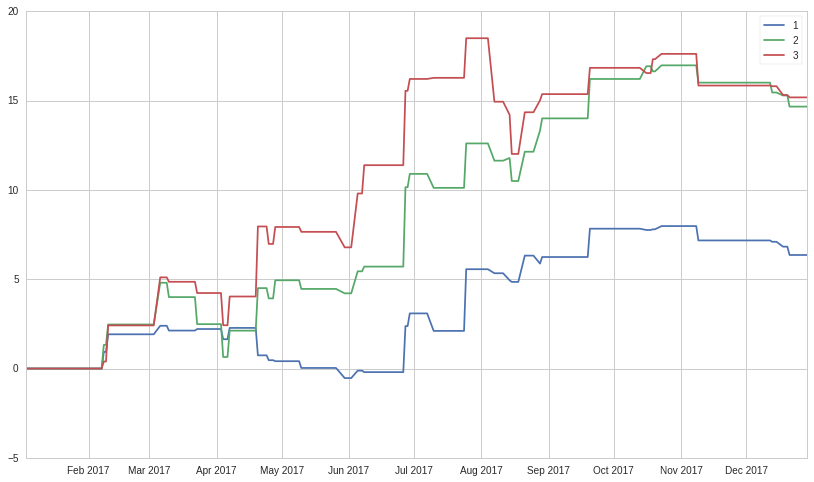

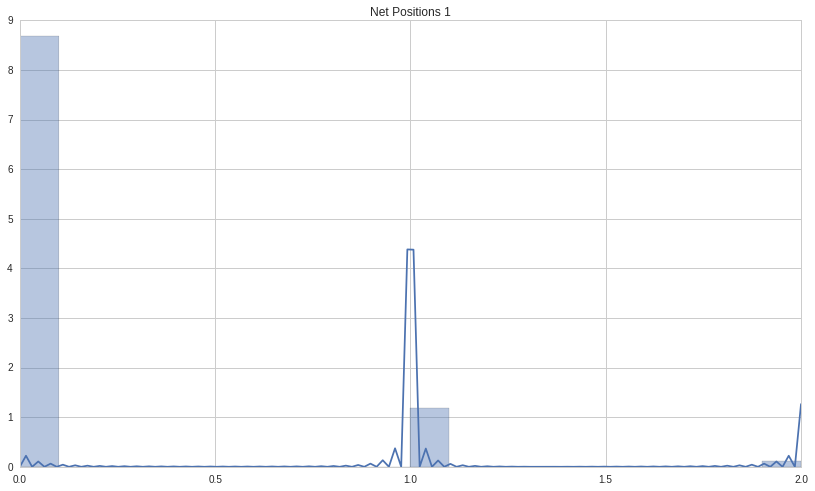

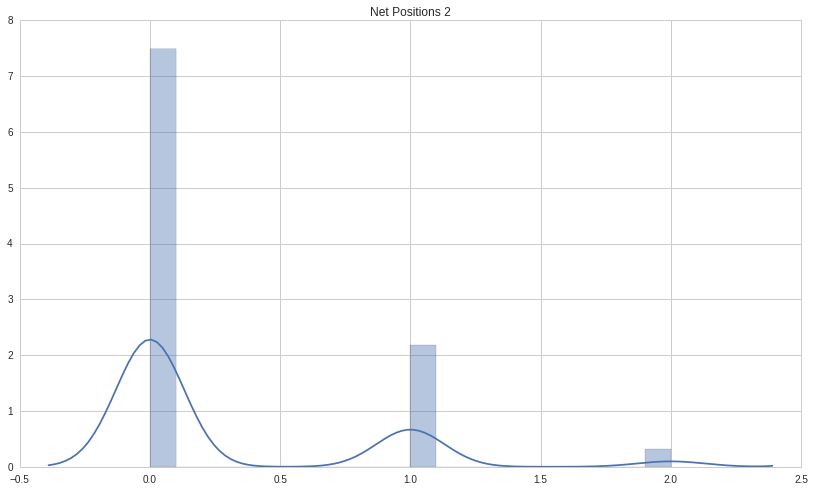

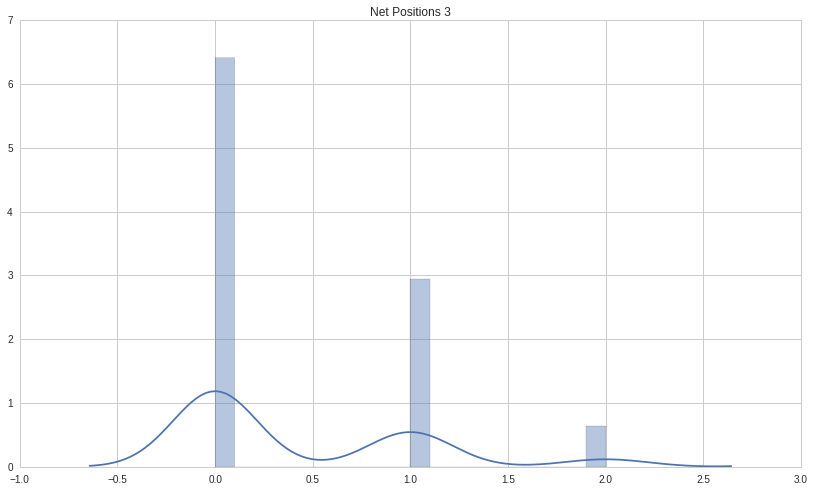

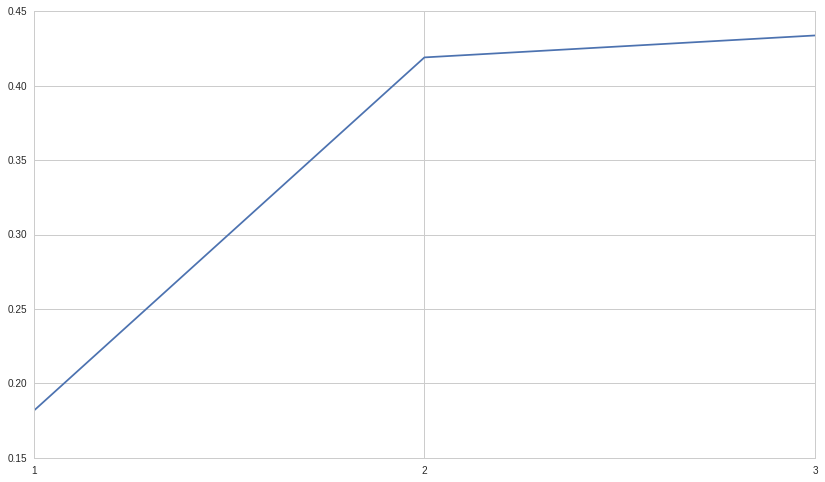

This strategy enters 35 long and short trades.


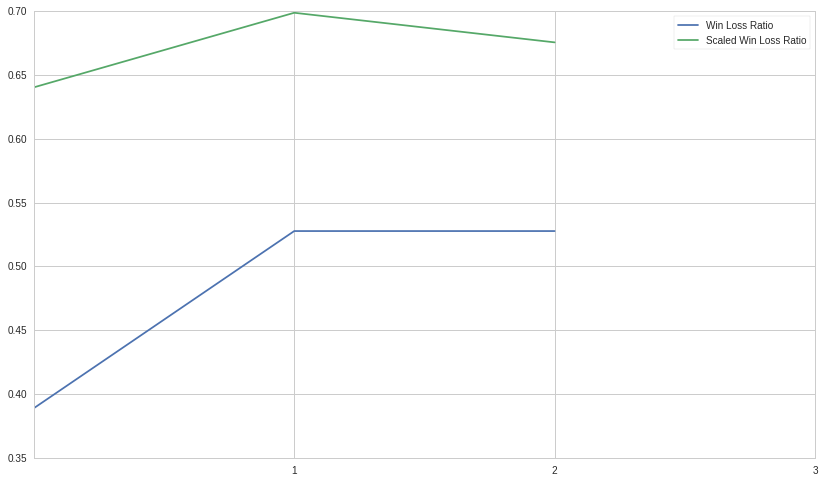

In [130]:
#priceRets is the new multi index dataframe with columns for OHLC and different forward returns
#user specifies the number of x stocks 
x = 100
d1 = '2017-01-01'
d2 = '2017-12-31'
freq = 'daily'
periodList = [1,2,3]    
visualDf1 = pd.DataFrame()

INDICATOR_NAME = 'CDLUNIQUE3RIVER'   
INDICATOR = find_indicator(INDICATOR_NAME)

priceRets = create_price_rets(x, d1, d2, freq, periodList, INDICATOR)

for period in periodList:
    visualDf1 = prep_visuals(visualDf1,priceRets,period)
    
plot_visuals(visualDf1,periodList,priceRets)
metrics_per_trade(priceRets,periodList)
plot_win_loss(priceRets,periodList)

In [128]:
def long_alternative(x,d1,d2,freq):
    myStocks = get_stocks(x, d1)
    priceData = get_pricing(myStocks, d1, d2, frequency=freq, fields=['volume','price']).fillna(0).to_frame()
    priceDiff = (priceData['price'].pct_change(x)*100).shift(-x).dropna()
        
    dividedPnL = priceDiff.groupby(level='major').apply(lambda col: np.sum(col))/float(x)
        
    plt.plot(np.cumsum(dividedPnL),label='Buy and Hold')

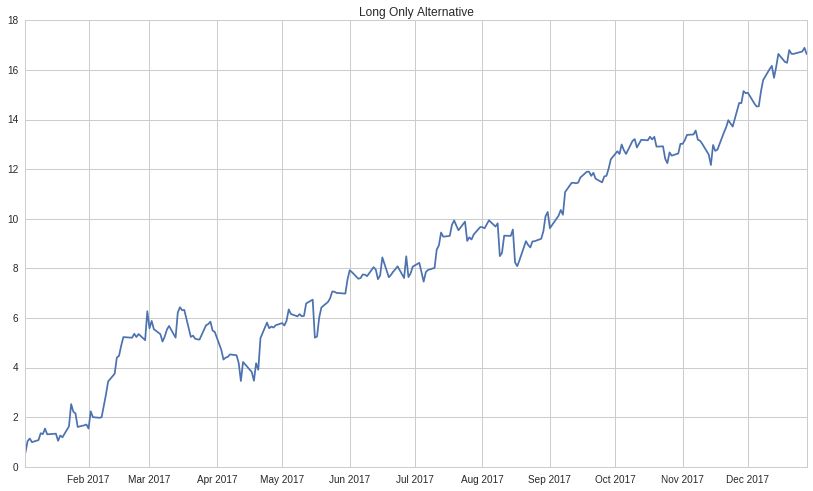

In [47]:
long_alternative(x,d1,d2,freq)
plt.title('Long Only Alternative')
plt.show()

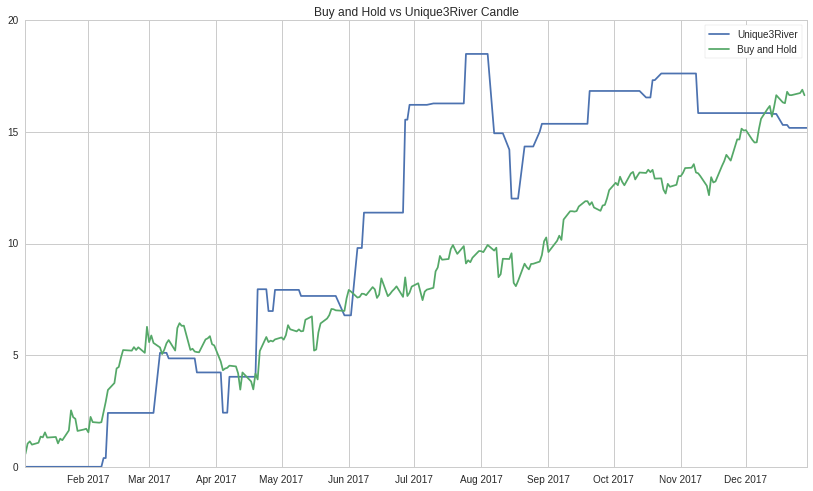

In [131]:
plt.plot(np.cumsum(visualDf1['meanPnL3']),label='Unique3River')
plt.title('Buy and Hold vs Unique3River Candle')
long_alternative(x,d1,d2,freq)
plt.legend()
plt.show()